In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [24]:
# Read CSVs
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
X_train_full = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv", index_col='PassengerId')
X_test_full = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv", index_col='PassengerId')

In [25]:
# Exploratory Data Analysis
# See main info
print(X_train_full.info())

# Base stats
display(X_train_full.describe())

# See if target is balanced
print(y.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB
None


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
dtype: float64


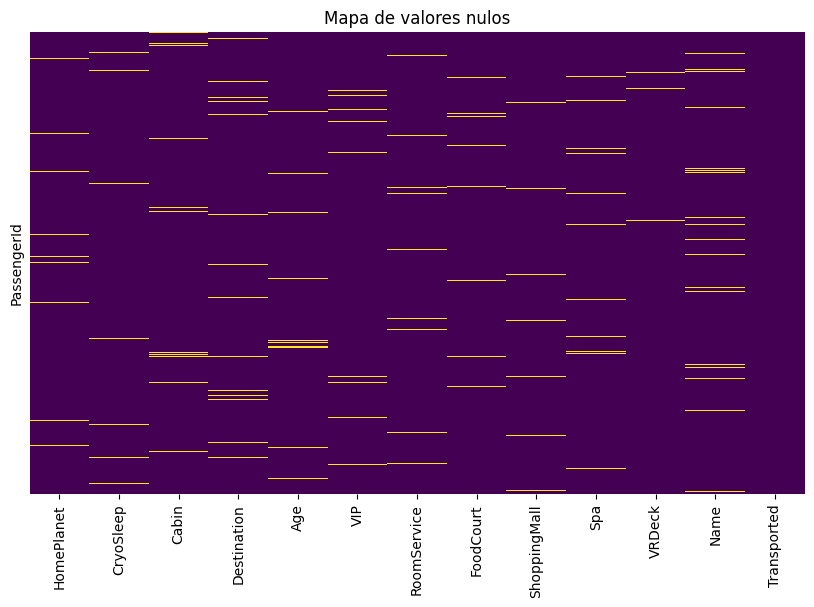

In [26]:
# Describe NULL values
# NULLs per column
nulos = X_train_full.isnull().sum()
print((nulos[nulos > 0] / len(X_train_full)) * 100)

import matplotlib.pyplot as plt
import seaborn as sns
# Graph
plt.figure(figsize=(10, 6))
sns.heatmap(X_train_full.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Mapa de valores nulos')
plt.show()

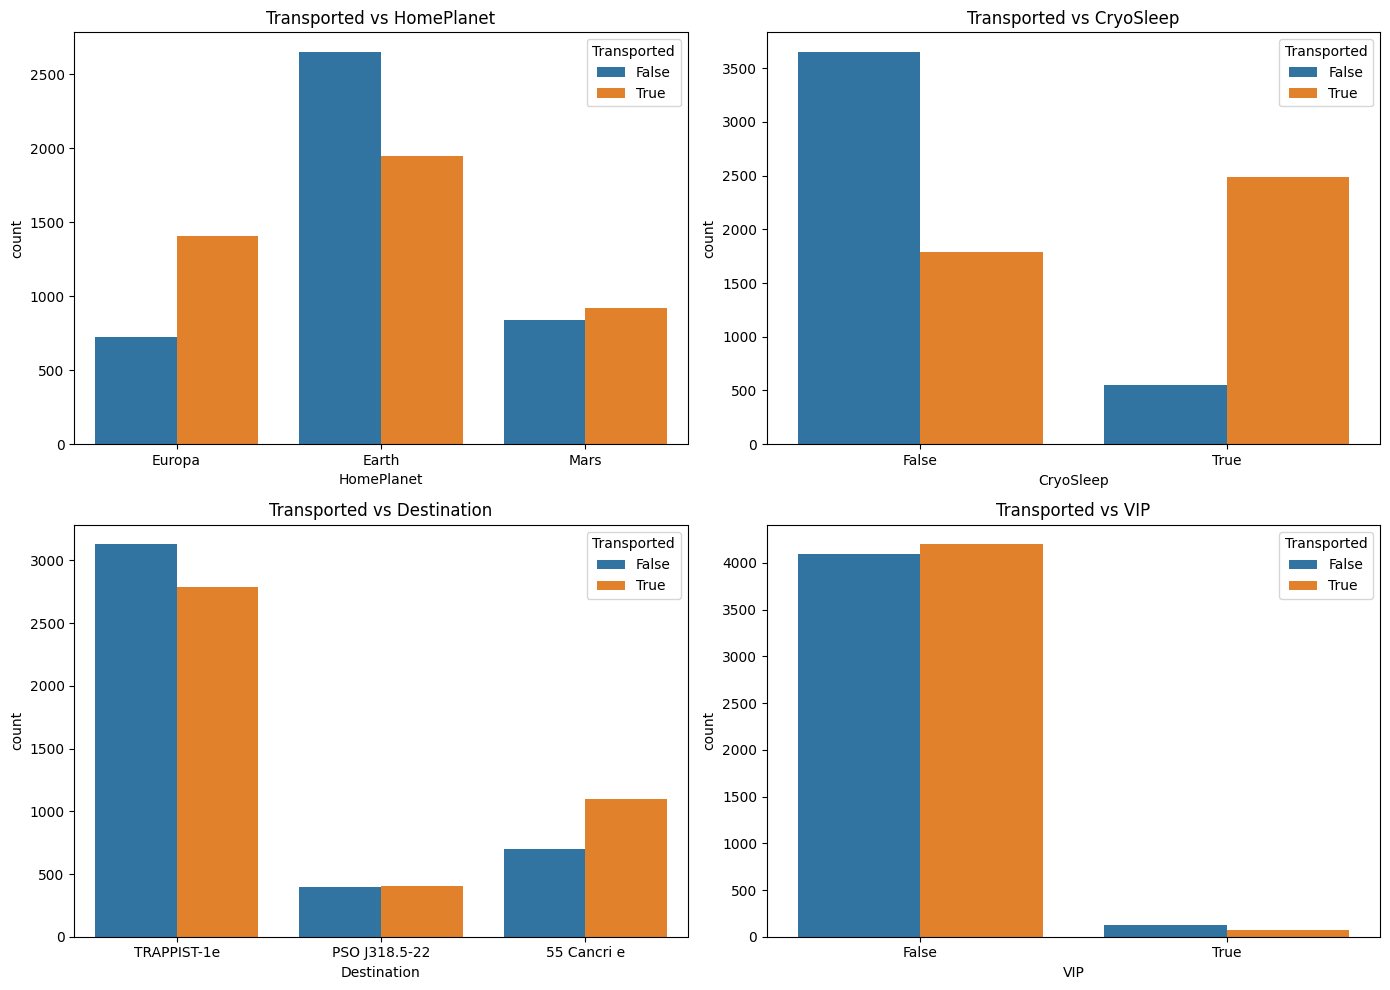

In [27]:
# Show categoric variables
df_eda = X_train_full.copy()
df_eda['Transported'] = y

cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(cat_features):
    ax = axes[i//2, i%2]
    # Compare with Transported column
    sns.countplot(data=df_eda, x=col, hue='Transported', ax=ax)
    ax.set_title(f'Transported vs {col}')

plt.tight_layout()
plt.show()

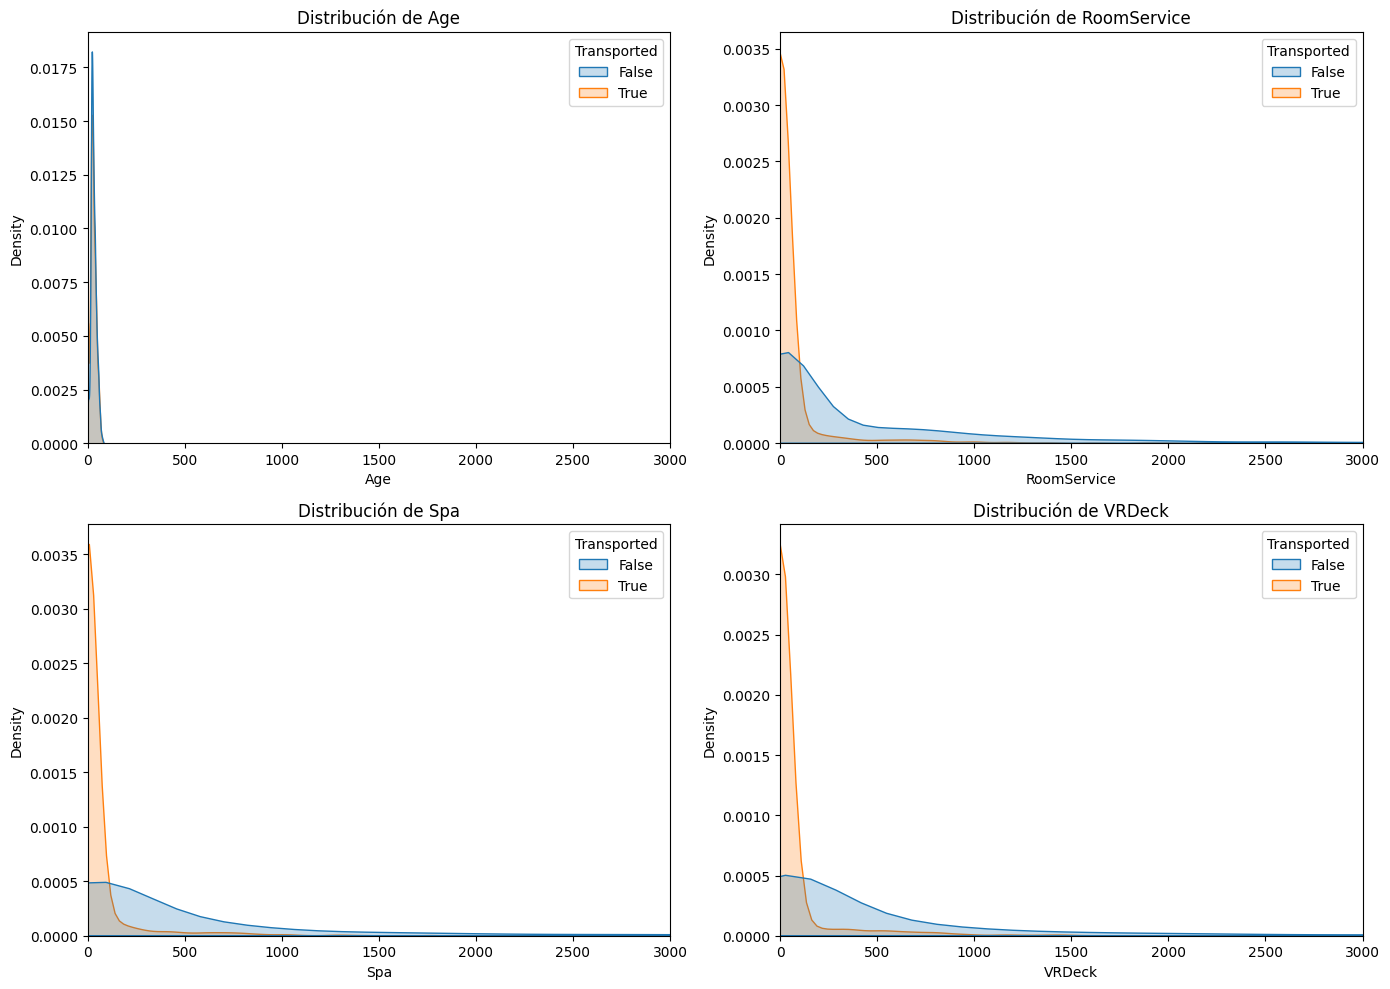

In [28]:
# Describe numerical features
num_features = ['Age', 'RoomService', 'Spa', 'VRDeck']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, col in enumerate(num_features):
    ax = axes[i//2, i%2]
    # Using KDE (Kernel Density Estimate)
    sns.kdeplot(data=df_eda, x=col, hue='Transported', fill=True, ax=ax)
    ax.set_title(f'Distribución de {col}')
    # Limit X axis
    ax.set_xlim(0, 3000) 

plt.tight_layout()
plt.show()

In [16]:
# Separate train and valid sets
from sklearn.model_selection import train_test_split

y = X_train_full["Transported"]
X = X_train_full.drop("Transported", axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
# Pre-process stage
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [19]:
# Select numeric columns
num_cols = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]

# Select text columns
cat_cols = [col for col in X_train.columns if X_train[col].dtype in ['object', 'category']]

In [20]:
# Numeric pipeline
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categoric pipeline
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [21]:
# Final preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [22]:
# Final pipeline
my_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [23]:
my_pipeline.fit(X_train, y_train)

# Eval valid set
from sklearn.metrics import accuracy_score

preds_valid = my_pipeline.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, preds_valid))

Accuracy: 0.7832087406555491
